<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#20-news-groups-load" data-toc-modified-id="20-news-groups-load-1">20 news groups load</a></span></li><li><span><a href="#Spectral-Clustering" data-toc-modified-id="Spectral-Clustering-2">Spectral Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3">PCA</a></span></li><li><span><a href="#SPECTRAL" data-toc-modified-id="SPECTRAL-4">SPECTRAL</a></span></li><li><span><a href="#SPECTRAL-V2" data-toc-modified-id="SPECTRAL-V2-5">SPECTRAL V2</a></span></li><li><span><a href="#3D" data-toc-modified-id="3D-6">3D</a></span></li></ul></div>

# 20 news groups load

In [1]:
import spectral
import scipy
from scipy import sparse
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

from sklearn import preprocessing, decomposition, model_selection

In [2]:
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
all_news = fetch_20newsgroups(subset='all')

In [4]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, sublinear_tf=True, max_features=500)

In [5]:
news_data = vectorizer.fit_transform(all_news.data)
news_target = all_news.target
news_target_names = all_news.target_names 

feature_names = vectorizer.get_feature_names()

In [6]:
subset_mask = np.random.permutation(len(news_target))[:4000]

X = scipy.sparse.csr_matrix.todense(news_data[subset_mask])
y = news_target[subset_mask]

In [7]:
df_targets = pd.DataFrame(news_target_names)

In [8]:
parent_cat = ['comp.', 'rec.', '.politics.', 'sci.', 'misc.forsale', 'religion' ]

parent_cat_ind = []
for c in parent_cat:
    ind = df_targets[df_targets[0].apply(lambda x: c in x).values].index.values
    if c == 'religion':
        ind = np.append(ind, 0)
    parent_cat_ind.append(ind)

In [9]:
def is_in(s):
    return np.vectorize(lambda x: x in s)

In [10]:
new_y = y.copy()
for i, s in enumerate(parent_cat_ind):
    m = is_in(s)(y)
    print(i, s, m)
    new_y[m] = i
    
y = new_y

0 [1 2 3 4 5] [False  True  True ..., False False False]
1 [ 7  8  9 10] [False False False ..., False False  True]
2 [16 17 18] [False False False ..., False False False]
3 [11 12 13 14] [ True False False ...,  True False False]
4 [6] [False False False ..., False False False]
5 [15 19  0] [False False False ..., False  True False]


targets = np.random.permutation(len(news_target_names))

mask = np.zeros_like(news_target, dtype=bool)
label_to_name = {}

for t in targets:
    name = news_target_names[t]
    label_to_name[t] = name
    print(name)
    mask = mask | (news_target == t)

# Spectral Clustering

In [11]:
distances = spectral.features_to_dist_matrix(X, metric='cosine')

if np.count_nonzero(np.isnan(distances)) > 0:
    print('there are some nan')
    distances = np.nan_to_num(distances)

In [12]:
all_weights = spectral.dist_to_adj_matrix(distances, 'gaussian')

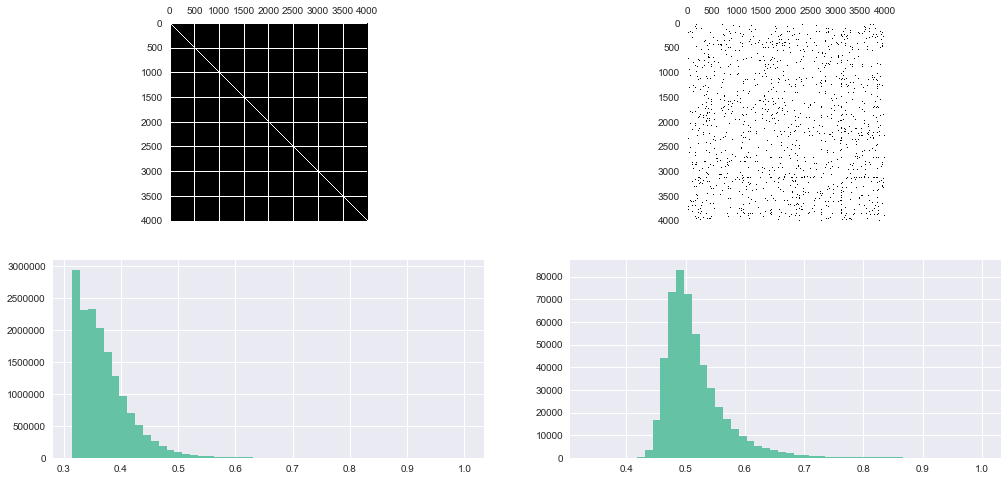

In [13]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

NEIGHBORS = 100
weights = spectral.filter_neighbors(all_weights, NEIGHBORS)

plot(all_weights, axes[:, 0])
plot(weights, axes[:, 1])

In [14]:
# Weighted degree distribution
degrees = np.sum(weights, axis=0)

In [15]:
D = np.diag(degrees)
W = weights
L = D - W

inv_sqrt_D = np.diag(1 / np.diag(D**(0.5)))

normalized_laplacian = inv_sqrt_D @ L @ inv_sqrt_D

In [16]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(normalized_laplacian, k=20, which='SM') # which='SA' gives us similar results

In [17]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [18]:
unsupervised_labels = (eigenvectors[:, 1] - eigenvectors[:, 2]) > 0

In [19]:
accuracy = spectral.compute_err(y, unsupervised_labels)

print('accuracy of {}%'.format(int(accuracy * 10000) / 100))

accuracy of -95.67%


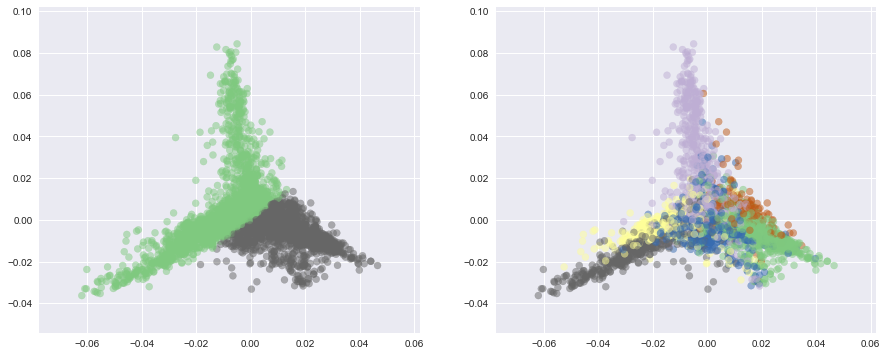

In [20]:
f, axes = plt.subplots(nrows=1, ncols=2)

for ax, lab in zip(axes.flatten(), [unsupervised_labels, y]):
    spectral.plot_labels(eigenvectors, lab, ax=ax)

# 3D

In [21]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [22]:
init_notebook_mode(connected=True)
print(__version__)

2.2.2


In [32]:
traces = []
labels_to_show = sorted(set(y))
labels_to_show.append(999)
label_to_name = {i:l for i, l in enumerate(labels_to_show)}
label_to_color[999] = 999

for label in labels_to_show:
    label_mask = y == label
    #'''
    axis_x = eigenvectors[:, 1][label_mask]
    axis_y = eigenvectors[:, 2][label_mask]
    axis_z = eigenvectors[:, 3][label_mask]
    '''
    axis_x = features_pca[:, 0][label_mask]
    axis_y = features_pca[:, 1][label_mask]
    axis_z = features_pca[:, 2][label_mask]
    #'''
    trace = go.Scatter3d(
        x=axis_x,
        y=axis_y,
        z=axis_z,
        name=label_to_color[label],
        mode='markers',
        marker=dict(
            size=12,
            color=label,
            #colorscale='Viridis',
            #opacity=0.8,
            line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
        )
    )
    
    traces.append(trace)

In [33]:
layout = go.Layout(
    hovermode= 'closest',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [34]:
data = traces

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [26]:
new_message = ["I like to use my apple computer to code"]

data = vectorizer.transform((new_message))

X = scipy.sparse.csr_matrix.todense(data)

def plot_new_point(message):
    data = vectorizer.transform((message))
    scipy.sparse.csr_matrix.todense(data)

In [35]:
y

array([3, 0, 0, ..., 3, 5, 1])